In [28]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import minimize
from dataclasses import dataclass

from qiskit.providers.fake_provider import FakeManila,FakeQuito,FakeLima,FakeKolkata,FakeNairobi
from qiskit.transpiler import CouplingMap

from qiskit.circuit import QuantumCircuit,ParameterVector,Parameter
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
#from qiskit.opflow import PauliSumOp
from qiskit.primitives import Estimator,Sampler,BackendEstimator
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SLSQP,COBYLA,L_BFGS_B,QNSPSA,SPSA
from qiskit_aer.noise import NoiseModel

from qiskit_ibm_runtime import Session,Options,QiskitRuntimeService
from qiskit_ibm_runtime import Estimator as IBM_Estimator
from qiskit_ibm_runtime import Sampler as IBM_Sampler

from qiskit_aer.primitives import Estimator as AerEstimator


# Variational simulation of boundary field phase transition in Ising chains

In this notebook I show how to implement the Variational Quantum Eigensolver to simulate the magnet-kink phase transition in a linear Ising chain with an opposite direction boundary field. The Hamiltonian for the system is given by

 \begin{align}
     H &= -J\sum_{i=1}^{L-1}Z_i Z_{i+1}   -h\sum_{i=1}^{L}X_i-g(Z_1 - Z_L),
 \end{align}
where J is the coupling, h is the transverse field and g is the boundary field. The crittical boundary field is given by $\,\, g_c = \sqrt{1-h}$.

The magnet-kink phase transition causes a sharp increase in the expectation value of number of kinks operator, defined as:

\begin{align}
    N_k = \frac{1}{2}\sum_{i=1}^{L-1}\mathbb{1} - Z_i Z_{i+1}
\end{align}

The formal analysis of the system can be found in the following references:

https://arxiv.org/abs/1501.03265

https://journals.aps.org/prb/abstract/10.1103/PhysRevB.103.024409



We define J, h, and the number of spins in the lattice as global variables. For J > h the system is in the ordered (ferromagnetic) phase, and since relevant phase transition is inside the ordered phase we set J = 1 and h = 0.5. We also define the number of spins in the lattice, which is the same as the number of qubits used in the VQE simulation.

In [29]:
J  = 1
h = 0.5 
n_qubits = 4 

We also create the networkx graph associated with the lattice

In [30]:
def get_line_graph(n_qubits):
    """This function creates a linear lattice with
    open boundary conditions for a given number of qubits"""
    graph_line = nx.Graph()
    graph_line.add_nodes_from(range(n_qubits))

    edge_list = []
    for i in graph_line.nodes:
        if i < n_qubits-1:
            edge_list.append((i,i+1))

    # Generate graph from the list of edges
    graph_line.add_edges_from(edge_list)
    return graph_line

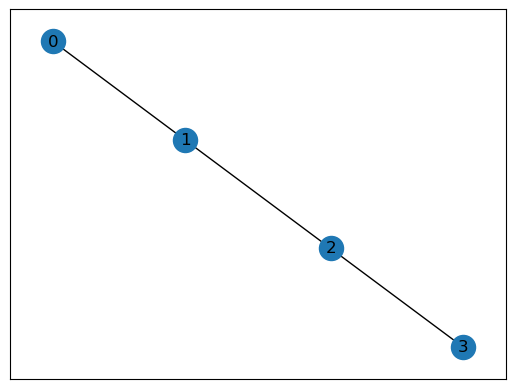

In [31]:
graph = get_line_graph(n_qubits)
nx.draw_networkx(graph) #plotting the graph

We define the functions that contruct the hamiltonian and number of kinks operators in the SparsePauliOp format

In [32]:
def get_h_op(graph,J=1.,hx=0.5,hz=0.,ap=0.):
    """Creates a general Ising hamiltonian  for
    given values of the coupling, transverse field,
    longitudinal field and antiparallel field
    Args:
        graph: networkx graph of the lattice
        J: uniform coupling between first neighbors
        hx: transverse field parameter
        hz: longitudinal field parameter
        ap: antiparallel field at the boundaries"""
    num_qubits = len(graph.nodes())
    sparse_list = []
    # Uniform Z and X fields
    for qubit in graph.nodes():
        # X field
        coeff = ('X',[qubit],-1*hx)
        sparse_list.append(coeff)
        # Z field
        coeff = ('Z',[qubit],-1*hz)
        sparse_list.append(coeff)

    # Anti-paralel field at the borders
    coeff = ('Z',[0],ap) #this is the positive field (order reversed)
    sparse_list.append(coeff)
    coeff = ('Z',[num_qubits-1],-1*ap)
    sparse_list.append(coeff)

    #Interaction field (ZZ)
    for i,j in graph.edges():
        coeff = ('ZZ',[i,j],-1*J)
        sparse_list.append(coeff)
    
    hamiltonian = SparsePauliOp.from_sparse_list(sparse_list,num_qubits=num_qubits).simplify()
    return hamiltonian

def get_kk_op(graph):
    """Creates the number of kinks operator"""
    sparse_list = []
    for i,j in graph.edges():
        coeff = ('II',[i,j],0.5)
        sparse_list.append(coeff)       
        coeff = ('ZZ',[i,j],-0.5)
        sparse_list.append(coeff)
    
    kk_op = SparsePauliOp.from_sparse_list(sparse_list,num_qubits=len(graph.nodes))
    return kk_op

In [33]:
# We show the Hamiltonian with the crittical boundary field as well as 
# the number of kinks 
print(get_h_op(graph,J,h,ap=np.sqrt(1-h))) 
print(get_kk_op(graph))

SparsePauliOp(['IIIX', 'IIXI', 'IXII', 'XIII', 'IIIZ', 'ZIII', 'IIZZ', 'IZZI', 'ZZII'],
              coeffs=[-0.5       +0.j, -0.5       +0.j, -0.5       +0.j, -0.5       +0.j,
  0.70710678+0.j, -0.70710678+0.j, -1.        +0.j, -1.        +0.j,
 -1.        +0.j])
SparsePauliOp(['IIII', 'IIZZ', 'IIII', 'IZZI', 'IIII', 'ZZII'],
              coeffs=[ 0.5+0.j, -0.5+0.j,  0.5+0.j, -0.5+0.j,  0.5+0.j, -0.5+0.j])


## Exact results

Here we construct the phase diagram of the system using exact diagonalization using numpy. This will serve as the benchmark for our VQE results.

First we define the range of values of the boundary field considered, as well the number of steps considered for the exact diagonalization resutls

In [34]:
exact_steps = 70
g_i = 0.
g_f = 1.6
exact_g_values = np.linspace(g_i,g_f,exact_steps)

In [35]:
def get_numpy_results(graph,J,h,g_values):
    """Returns the exact values of the energy and number of kinks
    for a given lattice, coupling, transverse field and values of
    the boundary field"""
    n_qubits = len(graph.nodes())
    numpy_solver = NumPyMinimumEigensolver()
    E_values = []
    kk_values = []
    kk_op = get_kk_op(graph) #getting the (g-independent) number of kinks operator
    
    for g in g_values:
        h_op = get_h_op(graph,J,h,ap=g) #getting the hamiltonian operator for each g value
        result = numpy_solver.compute_minimum_eigenvalue(operator=h_op,aux_operators=[kk_op])
        E_values.append(result.eigenvalue)
        kk_values.append(np.real(result.aux_operators_evaluated[0][0]))
    
    return E_values,kk_values

Here we plot the exact results, indicating the critical boundary field

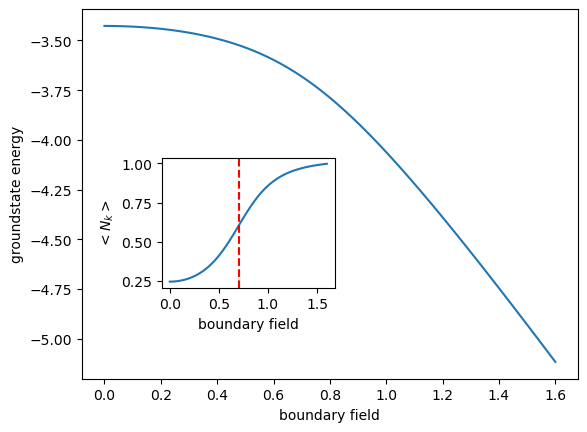

In [36]:
exact_E,exact_kk = get_numpy_results(graph,J,h,exact_g_values) # getting the exact energy and number of kinks
#Plotting
f,ax = plt.subplots()
plt.plot(exact_g_values,exact_E)
plt.xlabel('boundary field')
plt.ylabel('groundstate energy')

inset_ax = f.add_axes([0.25, 0.3, 0.27, 0.27])# [left, bottom, width, height]
inset_ax.plot(exact_g_values,exact_kk) 
inset_ax.set_ylabel('$<N_k>$')
inset_ax.set_xlabel('boundary field')
inset_ax.axvline(x=np.sqrt(1-h), color='red', linestyle='dashed') #indicating the critical boundary field
plt.show()

# VQE results

In [160]:
#Initialize runtime 
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='your_token'
)
backend = service.backend("ibmq_qasm_simulator")
shots = 2**14 # shots for noisy simulations

From now on we consider the Hamiltonian Variational Ansatz for our statevector (noiseless) simulations and the Hardware efficient ansatz (HEA) for our noisy simulations. We show draw the circuits used in both cases. We also define important fuctions that will be used in our implementation of the ZNE error mitigation protocol, specifically the extrapolation function and the folded ansatz generator for the HEA case

Hamiltonian variational ansatz

In [38]:
def get_ansatz_hva(graph, theta_list):
    """Creates the hamiltonian variaitonal ansatz for a given
    lattice graph and list of parameters. The parameters list must have a 
    lenght of 3*n_layers, and must have a form (coupling_i,transverse_i,boundary_i)
    Args:
        graph: lattice graph
        theta_list: list of parameters
    """
    n_qubits = len(graph.nodes())
    n_layers = len(theta_list)//3 

    qc = QuantumCircuit(n_qubits)
    
    even_edges = [edge for edge in graph.edges() if edge[0]%2==0]
    odd_edges = [edge for edge in graph.edges() if edge[0]%2!=0]
    
    # initial_state
    qc.h(range(n_qubits))
    for layer_index in range(n_layers):

        # Coupling term
        for pair in even_edges:
            qc.rzz(2 * theta_list[3*layer_index],pair[0],pair[1])
        for pair in odd_edges:
            qc.rzz(2 * theta_list[3*layer_index],pair[0],pair[1])
        # boundary field term
        qc.rz(2 *theta_list[3*layer_index+2],0)
        qc.rz(-2 * theta_list[3*layer_index+2], n_qubits-1) 
        # transverse field term
        qc.rx(2 * theta_list[3*layer_index+1], range(n_qubits))

    return qc


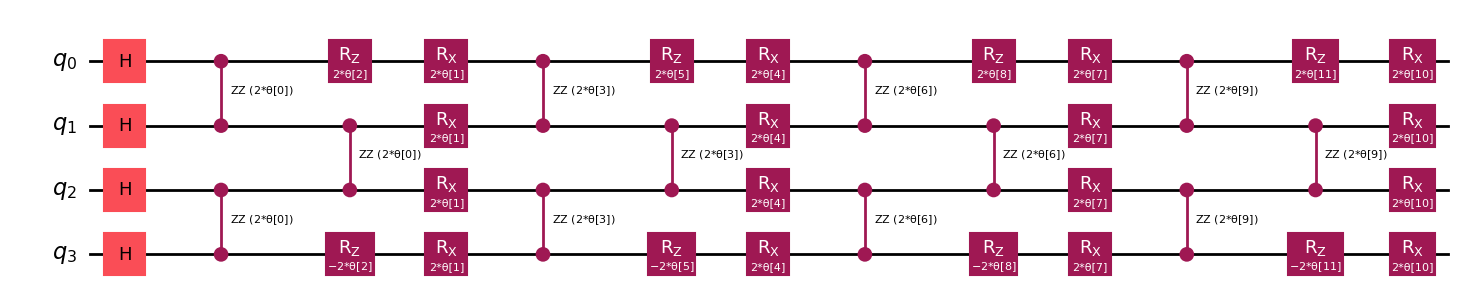

In [39]:
layers_hva = 4
theta_list_hva = ParameterVector('θ',3*layers_hva)
ansatz_hva = get_ansatz_hva(graph,theta_list_hva)
ansatz_hva.draw('mpl',style='iqx')


Hardware efficient ansatz

In [40]:
def get_ansatz_hea(graph,theta_list):
    """Creates the hardware efficient ansatz for a given
    lattice graph and list of parameters. The parameters list must have a 
    lenght of 2*n_qubits_n_layers
    Args:
        graph: lattice graph
        theta_list: list of parameters
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta_list)//(2*nqubits) 
    assert len(theta_list)==2*n_qubits*n_layers, "The list of parameters does not have the correct size"
    
    qc = QuantumCircuit(nqubits)
    
    even_edges = [edge for edge in graph.edges() if edge[0]%2==0]
    odd_edges = [edge for edge in graph.edges() if edge[0]%2!=0]
    reversed_edges = [edge for edge in graph.edges()][::-1]

    for layer_index in range(n_layers):
        for qubit in range(nqubits):
            qc.ry(theta_list[2*(nqubits)*layer_index+qubit], qubit)
        # for pair in reversed_edges:
        #     qc.cnot(pair[0],pair[1])
        for pair in even_edges:
            qc.cnot(pair[0],pair[1])
        for pair in odd_edges:
            qc.cnot(pair[0],pair[1])
        for qubit in range(nqubits):
            qc.ry(theta_list[nqubits+2*(nqubits)*layer_index+qubit], qubit)

    return qc

def get_ansatz_hea_ZNE(graph,theta_list):
    """Creates the folded version of  hardware efficient ansatz for a given
    lattice graph and list of parameters. The parameters list must have a 
    lenght of 2*n_qubits_n_layers. Used in the ZNE error mitigation protocol
    Args:
        graph: lattice graph
        theta_list: list of parameters
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta_list)//(2*nqubits) 
    assert len(theta_list)==2*n_qubits*n_layers, "The list of parameters does not have the correct size"
    
    qc = QuantumCircuit(nqubits)
    
    even_edges = [edge for edge in graph.edges() if edge[0]%2==0]
    odd_edges = [edge for edge in graph.edges() if edge[0]%2!=0]
    reversed_edges = [edge for edge in graph.edges()][::-1]

    for layer_index in range(n_layers):
        for qubit in range(nqubits):
            qc.ry(theta_list[2*(nqubits)*layer_index+qubit], qubit)
        # for pair in reversed_edges:
        #     qc.cnot(pair[0],pair[1])
        #folding even edges
        for pair in even_edges:
            qc.cnot(pair[0],pair[1])
        qc.barrier()
        for pair in even_edges:
            qc.cnot(pair[0],pair[1])
        qc.barrier()
        for pair in even_edges:
            qc.cnot(pair[0],pair[1])
        qc.barrier()
        #folding odd edges
        for pair in odd_edges:
            qc.cnot(pair[0],pair[1])
        qc.barrier()
        for pair in odd_edges:
            qc.cnot(pair[0],pair[1])
        qc.barrier()
        for pair in odd_edges:
            qc.cnot(pair[0],pair[1])
        qc.barrier()
        for qubit in range(nqubits):
            qc.ry(theta_list[nqubits+2*(nqubits)*layer_index+qubit], qubit)
        
        return qc


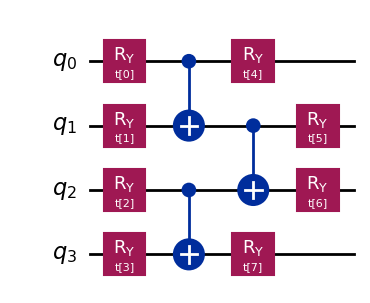

In [41]:
# Here we define and show the circuit for the HEA
layers_hea = 1
theta_list = ParameterVector('t',2*n_qubits*layers_hea) # The list of parameters must
ansatz_hea = get_ansatz_hea(graph,theta_list)
ansatz_hea.draw('mpl', style="iqx")

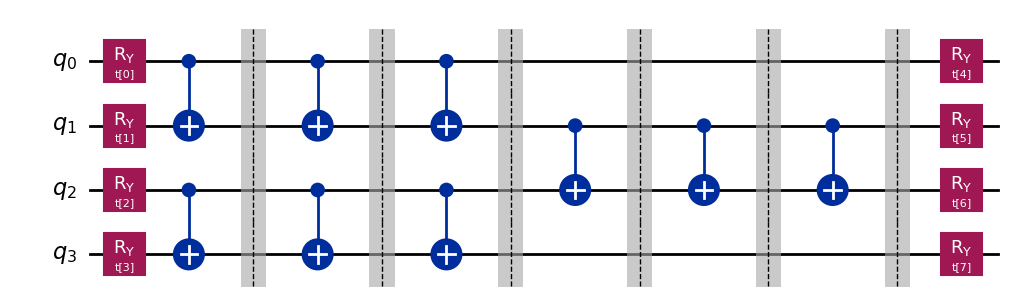

In [42]:
# Here is the folded version of the HEA ansatz for the ZNE
ansatz_hea = get_ansatz_hea_ZNE(graph,theta_list)
ansatz_hea.draw('mpl', style="iqx")

We define a function that selects the estimator between the standart estimator, backend estimator (for noisy simulations), and the runtime estimator. Aditionally we define the extrapolation function for the ZNE protocol

In [ ]:
def get_estimator(session,
                  server='qasm',
                  shots=2**14,
                  device=FakeKolkata(),
                  options_rtm=Options(),
                  seed=170):
    """Defines an estimator. Set 'qasm' for noiseless, 'noisy' for 
    backend estimator and 'rtm' for the runtime estimator"""
    if server =='qasm':
        estimator = Estimator(options={'shots':shots,'seed':seed})
    
    elif server == 'noisy':
        estimator = BackendEstimator(device,options={'shots':shots,'seed':seed})
    elif server ==  'rtm':
        estimator = IBM_Estimator(session=session,options=options_rtm)
        
    return estimator

def get_extrapolation(value_k1,value_k2,extrap='lin'):
    """Returns the exponential extrapolation given the 
    values for k=1 and k=2 noise factors"""
    k_values = [1.,2.]
    
    if extrap =='lin':
        y_values = [value_k1,value_k2]

        # Fit a linear regression model (polynomial of degree 1)
        coefficients = np.polyfit(k_values, y_values, 1)

        # The coefficients represent the slope (m) and y-intercept (b) of the line
        slope, intercept = coefficients

        extrapolation = intercept

    if extrap == 'exp':
        y_values = [np.abs(value_k1/value_k2),1.]
        ln_y = np.log(y_values)

        # Fit a linear regression model (polynomial of degree 1)
        coefficients_exp = np.polyfit(k_values, ln_y, 1)

        # The coefficients represent the slope (m) and y-intercept (b) of the line
        slope_exp, intercept_exp = coefficients_exp

        extrapolation = np.exp(intercept_exp)*value_k2

    
    return extrapolation

## Optimization profile

Here we apply the VQE to particular values of the boundary field to investigate the convergence of the optimization algorithm. We sample many times for initial parameters to verify the convergence across the parameter space.

### Statevector simulations (HVA)

In [44]:
def vqe_opt_scipy(graph,
               service,
               backend,
               g=0.7071067811865476,
               h=0.5,
               ansatz_str='hea',
               layers=1,
               optimizer='SLSQP',
               maxiter=50,
               ftol=0.,
               reps=1,
               zne=False,
               extrap='exp',
               shots=None,
               server='qasm',
               device=FakeNairobi(),
               options=Options()):
    """Runs the vqe for the Ising model with boundary fields for 
    a single value of the boundary field, using the scipy optimization function. 
    It gives data for the convergence of the  optimization, which is the logs for
    each sampling, the mean and standart deviation of these samplings, and also the 
    number of function evaluations
    Args:
        graph: networkx lattice graph
        service: service for runtime
        backend: backend for runtime (can include quantum backends)
        g: value of the boundary field
        h: value of the transverse field
        ansatz_str: choice of ansatz, 'hea' for HEA and 'hva' for HVA
        layers: number of layers for the ansatz
        optimizer: optimization algorithm, as string for scipy
        maxiter: maximum iterations for the optimization
        ftol: tolerance for convergence, for scipy
        reps: (int) number of initial parameters samplings
        zne: (bool) zne option
        extrap: type of extrapolation
        shots: number of shots, set to None for statevector simulations
        server: 'qasm' for noiseless, 'noisy' for aer, 'rtm' for runtime
        device: noise model for noisy simulations
        options: Options() class for runtime
        """
    
    n_qubits = len(graph.nodes())
    
    if ansatz_str == 'hea':
        theta_list = ParameterVector('θ',2*n_qubits*layers)
        ansatz = get_ansatz_hea(graph,theta_list)
        ansatz_k2 = get_ansatz_hea_ZNE(graph,theta_list)
    elif ansatz_str == 'hva':
        theta_list = ParameterVector('θ',3*layers)
        ansatz = get_ansatz_hva(graph,theta_list)
        ansatz_k2 = get_ansatz_hva(graph,theta_list)


    cost_operator = get_h_op(graph,hx=h,ap=g) #Defining Hamiltonian
    
    # Now we set the cost function, with no mitigation, linear or exp extrapolation
    if zne == False:
        def cost_function_vqe(theta):
            job = estimator.run(ansatz, cost_operator, theta)
            values = job.result().values[0]
            return values
    if zne == True:
        def cost_function_vqe(theta):
            job = estimator.run([ansatz,ansatz_k2], 2*[cost_operator], 2*[theta])
            value_k1 = job.result().values[0]
            value_k2 = job.result().values[1]
            extrapolation = get_extrapolation(value_k1=value_k1,value_k2=value_k2,extrap=extrap)
            return extrapolation             


    log_list = []
    nfev_list = []
    with Session(service=service,backend=backend) as session:
        estimator = get_estimator(server=server,
                                shots=shots,
                                device=device,
                                session=session,
                                options_rtm=options)
        for i in tqdm(range(reps)):
            random_point = np.random.random(ansatz.num_parameters)
            iter_list = []
            result_sample = minimize(cost_function_vqe,
                                     x0=random_point,
                                     method=optimizer,
                                     callback=lambda xk: iter_list.append(list(xk)),
                                     options={'maxiter':maxiter,'disp':False,'ftol':ftol})            
            iters = len(iter_list)
            energy_list = estimator.run(iters*[ansatz],iters*[cost_operator],iter_list).result().values
            nfev_list.append(int(result_sample.nfev))
            log_list.append(list(energy_list))

        session.close()

    max_length = max(len(sublist) for sublist in log_list)  # Finding the length of the largest list

    for sublist in log_list:
        if len(sublist) < max_length:
            last_element = sublist[-1]  # Extracting the last element
            sublist.extend([last_element] * (max_length - len(sublist)))  # Filling with the last element
    
    mean_list = []
    std_list = []
    for i in range(len(log_list[0])):
        values_list = [l[i] for l in log_list]
        mean_list.append(np.mean(values_list))
        std_list.append(np.std(values_list))
    
    return log_list,mean_list,std_list,nfev_list



We investigate the optimization for both the magnetic (g = 0.2) and kink (g = 1.2) phases. First we compute the exact energies

In [45]:
g_mag = 0.2
g_knk = 1.2

E_mag = NumPyMinimumEigensolver().compute_minimum_eigenvalue(get_h_op(graph,ap=g_mag)).eigenvalue
E_knk = NumPyMinimumEigensolver().compute_minimum_eigenvalue(get_h_op(graph,ap=g_knk)).eigenvalue

reps = 5 # we define the number of initial parameters samplings

Magnetic phase (g = 0.2)

In [46]:
logs_hva_mag,avgs_hva_mag,stds_hva_mag,nfevs_hva_mag = vqe_opt_scipy(graph=graph,
                                        service=service,
                                        backend=backend,
                                        server='qasm',
                                        g=g_mag,
                                        layers=layers_hva,
                                        ansatz_str='hva',
                                        reps=reps,
                                        maxiter=300,
                                        shots=None,
                                        ftol=1e-16)

100%|██████████| 5/5 [00:39<00:00,  7.98s/it]


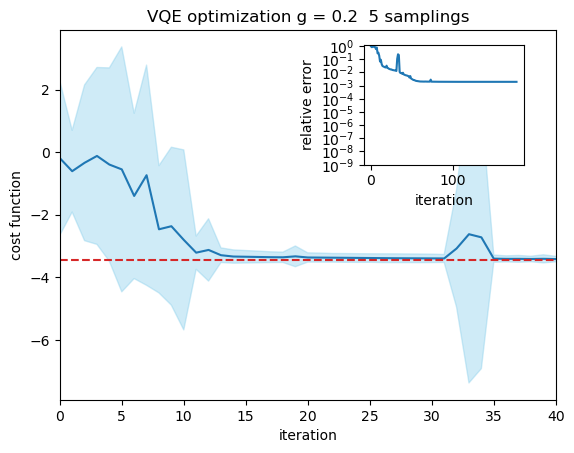

In [201]:
avgs_list = avgs_hva_mag
stds_list = stds_hva_mag
g_value = g_mag
exact_energy = E_mag

#Plots
x_values = np.arange(len(avgs_list))
f, ax = plt.subplots()
plt.plot(avgs_list)
# Calculating upper and lower bounds for the confidence interval
upper_bound = np.array(avgs_list) + 3 * np.array(stds_list)  # 3 sigmas
lower_bound = np.array(avgs_list) - 3 * np.array(stds_list)  # 3 sigmas
plt.fill_between(x_values, lower_bound, upper_bound, color='skyblue', alpha=0.4)
plt.axhline(y=exact_energy, color="tab:red", ls="--", label="exact")
plt.xlim((0,40))

x_lim = 60 
# plt.xlim(0,60)
plt.xlabel("iteration")
plt.ylabel("cost function")
plt.title(f"VQE optimization g = {np.round(g_value,3)}  {reps} samplings")


inset_ax = f.add_axes([0.6,0.6,0.25,0.25]) # [left, bottom, width, height]
inset_ax.plot([(exact_energy-avg)/exact_energy for avg in avgs_list])
inset_ax.set_yscale('log')
y_ticks = [10**i for i in range(-0, -10, -1)]  # Change the range to suit your needs
inset_ax.set_yticks(y_ticks)
inset_ax.set_xlabel("iteration")
inset_ax.set_ylabel("relative error")
plt.show()

Kink phase (g = 1.2)

In [48]:
logs_hva_knk,avgs_hva_knk,stds_hva_knk,nfevs_hva_knk = vqe_opt_scipy(graph=graph,
                                        service=service,
                                        backend=backend,
                                        server='qasm',
                                        g=g_knk,
                                        layers=layers_hva,
                                        ansatz_str='hva',
                                        reps=reps,
                                        maxiter=300,
                                        shots=None,
                                        ftol=1e-16)

100%|██████████| 5/5 [00:57<00:00, 11.44s/it]


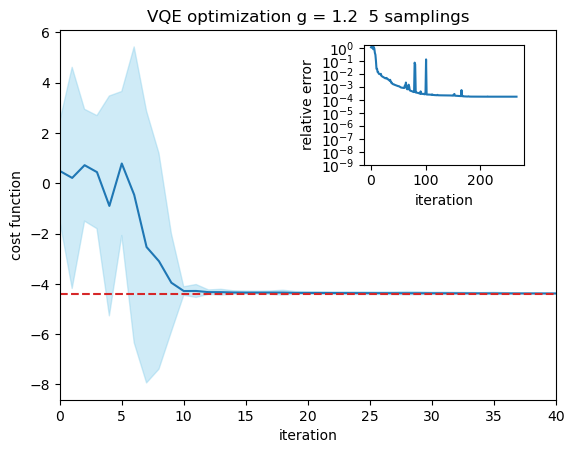

In [200]:
avgs_list = avgs_hva_knk
stds_list = stds_hva_knk
g_value = g_knk
exact_energy = E_knk

#Plots
x_values = np.arange(len(avgs_list))
f, ax = plt.subplots()
plt.plot(avgs_list)
# Calculating upper and lower bounds for the confidence interval
upper_bound = np.array(avgs_list) + 3 * np.array(stds_list)  # 3 sigmas
lower_bound = np.array(avgs_list) - 3 * np.array(stds_list)  # 3 sigmas
plt.fill_between(x_values, lower_bound, upper_bound, color='skyblue', alpha=0.4)
plt.axhline(y=exact_energy, color="tab:red", ls="--", label="exact")
plt.xlim((0,40))

x_lim = 60 
# plt.xlim(0,60)
plt.xlabel("iteration")
plt.ylabel("cost function")
plt.title(f"VQE optimization g = {np.round(g_value,3)}  {reps} samplings")


inset_ax = f.add_axes([0.6,0.6,0.25,0.25]) # [left, bottom, width, height]
inset_ax.plot([(exact_energy-avg)/exact_energy for avg in avgs_list])
inset_ax.set_yscale('log')
y_ticks = [10**i for i in range(-0, -10, -1)]  # Change the range to suit your needs
inset_ax.set_yticks(y_ticks)
inset_ax.set_xlabel("iteration")
inset_ax.set_ylabel("relative error")
plt.show()

### Noisy simulations (HEA)

Now we consider noisy simulations results using the noise models provided by qiskit. Because of the noise modeling, this section takes a more time to run.

In [50]:
# Here we define a different callback which is suited for the SPSA implementation of qiskit

intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'step_size': [],
    'step_sucesss': []
}

def callback(nfev, parameters, energy, step_size,step_sucess):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['step_size'].append(step_size)
    intermediate_info['step_sucess'].append(step_sucess)

    
@dataclass
class VQELog:
    values: list
    parameters: list

    def update(self, count, parameters, mean, step_size, step_sucess):
        self.values.append(mean)
        self.parameters.append(parameters)
        print(f"Running circuit {count}", end="\r", flush=True)

# Here is the main function
def vqe_critical_spsa(graph,
               service,
               backend,
               device=FakeKolkata(),
               g=0.7071067811865476,
               layers=1,
               server='qasm',
               learning_rate=0.07,
               perturbation=0.1,
               maxiter=200,
               hx=0.5,
               options=Options(),
               zne=False,
               extrap='exp',
               reps=1,
               shots=2**14,
               ansatz_str='hea'):
    """Runs the vqe for the Ising model with boundary fields for 
    a single value of the boundary field, using the scipy optimization function. 
    It gives data for the convergence of the  optimization, which is the logs for
    each sampling, the mean and standart deviation of these samplings, and also the 
    number of function evaluations
    Args:
        graph: networkx lattice graph
        service: service for runtime
        backend: backend for runtime (can include quantum backends)
        g: value of the boundary field
        h: value of the transverse field
        ansatz_str: choice of ansatz, 'hea' for HEA and 'hva' for HVA
        layers: number of layers for the ansatz
        maxiter: maximum iterations for the optimization
        learning_rate: learning rate for the SPSA optimizer
        perturbation: perturbation for the SPSA optimizer
        reps: (int) number of initial parameters samplings
        zne: (bool) zne option
        extrap: type of extrapolation
        shots: number of shots, set to None for statevector simulations
        server: 'qasm' for noiseless, 'noisy' for aer, 'rtm' for runtime
        device: noise model for noisy simulations
        options: Options() class for runtime
        """
    
    n_qubits = len(graph.nodes())
    
    if ansatz_str == 'hea':
        theta_list = ParameterVector('θ',2*n_qubits*layers)
        ansatz = get_ansatz_hea(graph,theta_list)
        ansatz_k2 = get_ansatz_hea_ZNE(graph,theta_list)
    elif ansatz_str == 'hva':
        theta_list = ParameterVector('θ',3*layers)
        ansatz = get_ansatz_hva(graph,theta_list)
        ansatz_k2 = get_ansatz_hva(graph,theta_list)


    cost_operator = get_h_op(graph,hx=hx,ap=g) #Defining Hamiltonian
    
    # Now we set the cost function, with no mitigation, linear or exp extrapolation
    if zne == False:
        def cost_function_vqe(theta):
            job = estimator.run(ansatz, cost_operator, theta)
            values = job.result().values[0]
            return values
    if zne == True:
        def cost_function_vqe(theta):
            job = estimator.run([ansatz,ansatz_k2], 2*[cost_operator], 2*[theta])
            value_k1 = job.result().values[0]
            value_k2 = job.result().values[1]
            return get_extrapolation(value_k1=value_k1,value_k2=value_k2,extrap=extrap)              


    log_list = []
    nfev_list = []
    with Session(service=service,backend=backend) as session:
        # estimator = BackendEstimator(FakeNairobiV2(),options={'shots':shots})
        estimator = get_estimator(server=server,
                                shots=shots,
                                device=device,
                                session=session,
                                options_rtm=options)
        for i in tqdm(range(reps)):
            log = VQELog([], [])
            spsa = SPSA(maxiter=maxiter,
                        trust_region=True,
                        learning_rate=learning_rate,
                        perturbation=perturbation,
                        callback=log.update)
            random_point = np.random.random(ansatz.num_parameters)
            result_sample = spsa.minimize(cost_function_vqe,x0=random_point)
            log_list.append(log)
            nfev_list.append(result_sample.nfev)
        session.close()
    max_length = max(len(sublist.values) for sublist in log_list)  # Finding the length of the largest list

    for sublist in log_list:
        if len(sublist.values) < max_length:
            last_element = sublist[-1]  # Extracting the last element
            sublist = list(sublist)[:].extend([last_element] * (max_length - len(sublist)))  # Filling with the last element
    


    mean_list = []
    std_list = []
    for i in range(len(log_list[0].values)):
        values_list = [log.values[i] for log in log_list]
        mean_list.append(np.mean(values_list))
        std_list.append(np.std(values_list))
    
    return log_list,mean_list,std_list,nfev_list

Magnetic phase (g = 0.2)

Noisy results

In [51]:
logs_hea_noisy_mag,avgs_hea_noisy_mag,stds_hea_noisy_mag,nfevs_hea_noisy_mag = vqe_critical_spsa(graph=graph,
                                        service=service,
                                        backend=backend,
                                        device=FakeKolkata(),
                                        g=g_mag,
                                        server='noisy',
                                        layers=1,
                                        maxiter=170,
                                        ansatz_str='hea',
                                        reps=5,
                                        zne=False,
                                        shots = shots
                                        )

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [06:04<24:16, 364.25s/it]

 40%|████      | 2/5 [12:35<18:59, 379.86s/it]

 60%|██████    | 3/5 [19:06<12:50, 385.03s/it]

 80%|████████  | 4/5 [25:01<06:13, 373.24s/it]

100%|██████████| 5/5 [30:48<00:00, 369.74s/it]


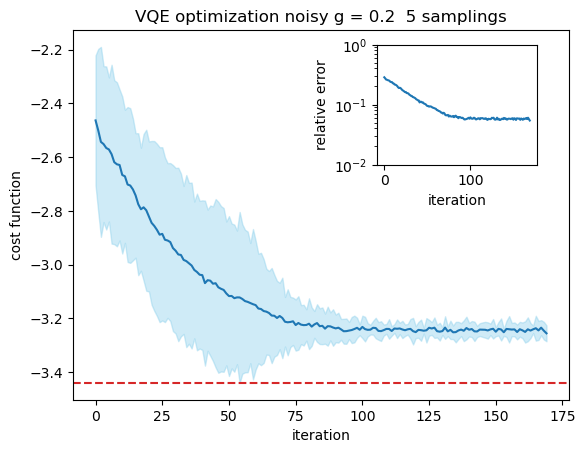

In [152]:
avgs_list = avgs_hea_noisy_mag
stds_list = stds_hea_noisy_mag
g_value = g_mag
exact_energy = E_mag

#Plots
x_values = np.arange(len(avgs_list))
f, ax = plt.subplots()
plt.plot(avgs_list)
# Calculating upper and lower bounds for the confidence interval
upper_bound = np.array(avgs_list) + 3 * np.array(stds_list)  # 3 sigmas
lower_bound = np.array(avgs_list) - 3 * np.array(stds_list)  # 3 sigmas
plt.fill_between(x_values, lower_bound, upper_bound, color='skyblue', alpha=0.4)
plt.axhline(y=exact_energy, color="tab:red", ls="--", label="exact")

plt.xlabel("iteration")
plt.ylabel("cost function")
plt.title(f"VQE optimization noisy g = {np.round(g_value,3)}  {reps} samplings")


inset_ax = f.add_axes([0.6,0.6,0.25,0.25]) # [left, bottom, width, height]
inset_ax.plot([(exact_energy-avg)/exact_energy for avg in avgs_list])
inset_ax.set_yscale('log')
y_ticks = [10**i for i in range(-0, -3, -1)]  # Change the range to suit your needs
inset_ax.set_yticks(y_ticks)
inset_ax.set_xlabel("iteration")
inset_ax.set_ylabel("relative error")
plt.show()

ZNE results

In [55]:
reps = 3
logs_hea_zne_mag,avgs_hea_zne_mag,stds_hea_zne_mag,nfevs_hea_zne_mag = vqe_critical_spsa(graph=graph,
                                        service=service,
                                        backend=backend,
                                        device=FakeKolkata(),
                                        g=g_mag,
                                        server='noisy',
                                        layers=1,
                                        maxiter=170,
                                        ansatz_str='hea',
                                        reps=reps,
                                        zne=True,
                                        extrap='exp',
                                        shots=shots
                                        )

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [10:07<20:14, 607.44s/it]

 67%|██████▋   | 2/3 [20:11<10:05, 605.51s/it]

100%|██████████| 3/3 [29:43<00:00, 594.59s/it]


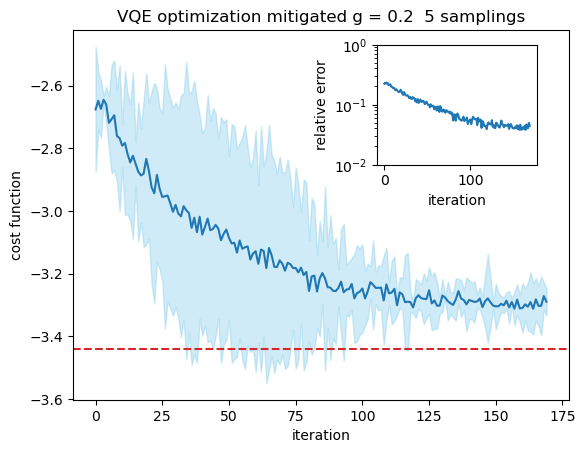

In [153]:
avgs_list = avgs_hea_zne_mag
stds_list = stds_hea_zne_mag
g_value = g_mag
exact_energy = E_mag

#Plots
x_values = np.arange(len(avgs_list))
f, ax = plt.subplots()
plt.plot(avgs_list)
# Calculating upper and lower bounds for the confidence interval
upper_bound = np.array(avgs_list) + 3 * np.array(stds_list)  # 3 sigmas
lower_bound = np.array(avgs_list) - 3 * np.array(stds_list)  # 3 sigmas
plt.fill_between(x_values, lower_bound, upper_bound, color='skyblue', alpha=0.4)
plt.axhline(y=exact_energy, color="tab:red", ls="--", label="exact")

x_lim = 60 
# plt.xlim(0,60)
plt.xlabel("iteration")
plt.ylabel("cost function")
plt.title(f"VQE optimization mitigated g = {np.round(g_value,3)}  {reps} samplings")


inset_ax = f.add_axes([0.6,0.6,0.25,0.25]) # [left, bottom, width, height]
inset_ax.plot([(exact_energy-avg)/exact_energy for avg in avgs_list])
inset_ax.set_yscale('log')
y_ticks = [10**i for i in range(-0, -3, -1)]  # Change the range to suit your needs
inset_ax.set_yticks(y_ticks)
inset_ax.set_xlabel("iteration")
inset_ax.set_ylabel("relative error")
plt.show()

Kink phase (g = 1.2)

Noisy results

In [58]:
logs_hea_noisy_knk,avgs_hea_noisy_knk,stds_hea_noisy_knk,nfevs_hea_noisy_knk = vqe_critical_spsa(graph=graph,
                                        service=service,
                                        backend=backend,
                                        device=FakeKolkata(),
                                        g=g_knk,
                                        server='noisy',
                                        layers=1,
                                        maxiter=170,
                                        ansatz_str='hea',
                                        reps=reps,
                                        zne=False,
                                        shots=shots
                                        )

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [06:08<24:33, 368.30s/it]

 40%|████      | 2/5 [12:19<18:29, 369.75s/it]

 60%|██████    | 3/5 [18:29<12:20, 370.17s/it]

 80%|████████  | 4/5 [24:37<06:09, 369.40s/it]

100%|██████████| 5/5 [31:12<00:00, 374.41s/it]


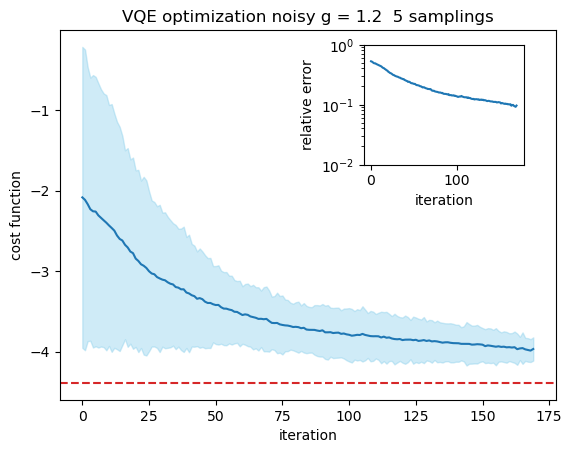

In [155]:
avgs_list = avgs_hea_noisy_knk
stds_list = stds_hea_noisy_knk
g_value = g_knk
exact_energy = E_knk

#Plots
x_values = np.arange(len(avgs_list))
f, ax = plt.subplots()
plt.plot(avgs_list)
# Calculating upper and lower bounds for the confidence interval
upper_bound = np.array(avgs_list) + 3 * np.array(stds_list)  # 3 sigmas
lower_bound = np.array(avgs_list) - 3 * np.array(stds_list)  # 3 sigmas
plt.fill_between(x_values, lower_bound, upper_bound, color='skyblue', alpha=0.4)
plt.axhline(y=exact_energy, color="tab:red", ls="--", label="exact")


x_lim = 60 
# plt.xlim(0,60)
plt.xlabel("iteration")
plt.ylabel("cost function")
plt.title(f"VQE optimization noisy g = {np.round(g_value,3)}  {reps} samplings")


inset_ax = f.add_axes([0.6,0.6,0.25,0.25]) # [left, bottom, width, height]
inset_ax.plot([(exact_energy-avg)/exact_energy for avg in avgs_list])
inset_ax.set_yscale('log')
y_ticks = [10**i for i in range(-0, -3, -1)]  # Change the range to suit your needs
inset_ax.set_yticks(y_ticks)
inset_ax.set_xlabel("iteration")
inset_ax.set_ylabel("relative error")
plt.show()

In [60]:
reps = 3 
logs_hea_zne_knk,avgs_hea_zne_knk,stds_hea_zne_knk,nfevs_hea_zne_knk = vqe_critical_spsa(graph=graph,
                                        service=service,
                                        backend=backend,
                                        device=FakeKolkata(),
                                        g=g_knk,
                                        server='noisy',
                                        layers=1,
                                        maxiter=170,
                                        ansatz_str='hea',
                                        reps=reps,
                                        zne=True,
                                        extrap='exp',
                                        shots=shots
                                        )

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [10:11<20:23, 611.80s/it]

 67%|██████▋   | 2/3 [20:29<10:15, 615.41s/it]

100%|██████████| 3/3 [30:45<00:00, 615.25s/it]


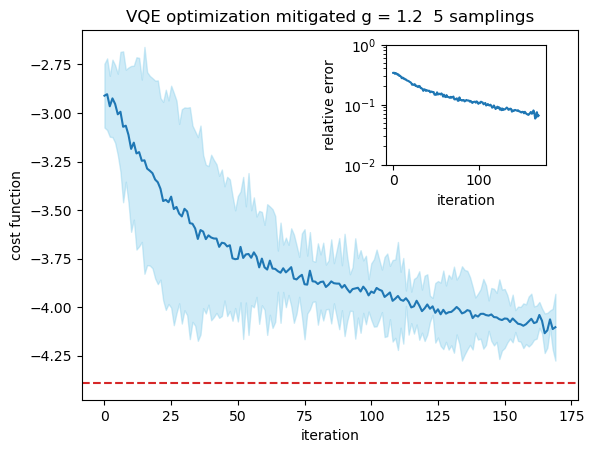

In [154]:
avgs_list = avgs_hea_zne_knk
stds_list = stds_hea_zne_knk
g_value = g_knk
exact_energy = E_knk

#Plots
x_values = np.arange(len(avgs_list))
f, ax = plt.subplots()
plt.plot(avgs_list)
# Calculating upper and lower bounds for the confidence interval
upper_bound = np.array(avgs_list) + 3 * np.array(stds_list)  # 3 sigmas
lower_bound = np.array(avgs_list) - 3 * np.array(stds_list)  # 3 sigmas
plt.fill_between(x_values, lower_bound, upper_bound, color='skyblue', alpha=0.4)
plt.axhline(y=exact_energy, color="tab:red", ls="--", label="exact")

# plt.xlim(0,60)
plt.xlabel("iteration")
plt.ylabel("cost function")
plt.title(f"VQE optimization mitigated g = {np.round(g_value,3)}  {reps} samplings")


inset_ax = f.add_axes([0.6,0.6,0.25,0.25]) # [left, bottom, width, height]
inset_ax.plot([(exact_energy-avg)/exact_energy for avg in avgs_list])
inset_ax.set_yscale('log')
y_ticks = [10**i for i in range(-0, -3, -1)]  # Change the range to suit your needs
inset_ax.set_yticks(y_ticks)
inset_ax.set_xlabel("iteration")
inset_ax.set_ylabel("relative error")
plt.show()

## Phase diagram 

Now we run the the VQE for various values of the boundary field to reproduce the phase diagram obtained via exact diagonalization. We define a single function that performs the VQE for both the statevector and noisy results. We also define a function that takes the optimal parameters and runs the circuit one last time so we can compute the number of kinks. This last function will also be useful for the runtime applications

In [189]:
def vqe_phase_diagram(graph,
               g_values,
               optimizer,
               init_optimizer,
               service,
               backend,
               server='qasm',
               device=FakeNairobi(),
               angles_dict = {},
               layers=1,
               hx=0.5,
               options=Options(),
               zne=False,
               extrap='exp',
               init_reps=1,
               shots=2**14,
               ansatz_str='hea'):
    """Runs the vqe to simulate the antiparallel model in
    the hardware efficient ansatz for different values of
    the antiparallel field. Returns the list of energies as 
    well as a dictionary with the optimal angles for each
    value of the boundary field.
    Args:
    graph: networkx lattice graph
    g_values: list of values for the boundary field
    angles_dict: dictionary of angles
    optimizer: qiskit optimizer class
    init_optimizer: optimizer for the first point
    layers: layers for the ansatz
    service: service for runtime
    backend: backend for runtime (can include quantum backends)
    h: value of the transverse field
    ansatz_str: choice of ansatz, 'hea' for HEA and 'hva' for HVA
    reps: number of initial parameters samplings for the first point
    zne: (bool) zne option
    extrap: type of extrapolation
    shots: number of shots, set to None for statevector simulations
    server: 'qasm' for noiseless, 'noisy' for aer, 'rtm' for runtime
    device: noise model for noisy simulations
    options: Options() class for runtime
    """
    
    n_qubits = len(graph.nodes())
    
    if ansatz_str == 'hea':
        theta_list = ParameterVector('θ',2*n_qubits*layers)
        ansatz = get_ansatz_hea(graph,theta_list)
        ansatz_k2 = get_ansatz_hea_ZNE(graph,theta_list)
    elif ansatz_str == 'hva':
        theta_list = ParameterVector('θ',3*layers)
        ansatz = get_ansatz_hva(graph,theta_list)
        ansatz_k2 = get_ansatz_hva(graph,theta_list)

    
    E_values = []
    rev_g_values = g_values[::-1]
    for i,g in enumerate(tqdm(rev_g_values)):
        cost_operator = get_h_op(graph,hx=hx,ap=g) #Defining Hamiltonian
        
        # Now we set the cost function, with no mitigation, linear or exp extrapolation
        if zne == False:
            def cost_function_vqe(theta):
                job = estimator.run(ansatz, cost_operator, theta)
                values = job.result().values[0]
                return values
        if zne == True:
            def cost_function_vqe(theta):
                job = estimator.run([ansatz,ansatz_k2], 2*[cost_operator], 2*[theta])
                value_k1 = job.result().values[0]
                value_k2 = job.result().values[1]
                return get_extrapolation(value_k1=value_k1,value_k2=value_k2,extrap=extrap)              


        if i == 0:
            sample = 0.
            for j in range(init_reps): #Performs sampling of initial parameters for the first point
                initial_point = np.random.uniform(0., 2*np.pi, size=ansatz.num_parameters)
                with Session(service=service,backend=backend) as session:
                    estimator = get_estimator(server=server,
                                            shots=shots,
                                            device=device,
                                            session=session,
                                            options_rtm=options)
                    result_sample = init_optimizer.minimize(fun=cost_function_vqe,
                    x0=initial_point)
                    session.close()
                if result_sample.fun < sample:
                    sample = result_sample.fun
                    result = result_sample
            initial_point = result.x
                        

        else:
            with Session(service=service,backend=backend) as session:
                estimator = get_estimator(server=server,
                                          shots=shots,
                                          device=device,
                                          session=session,
                                          options_rtm=options)
                result = optimizer.minimize(fun=cost_function_vqe,
                x0=initial_point)
                session.close()
    
        E_values.append(result.fun)
        #optimal angles storage
        angles = list(result.x)
        angles_dict[str(round(g,5))] = angles
    
    return E_values,angles_dict

def vqe_optimal(graph,
               service,
               backend,
               angles_opt,
               server='qasm',
               device=FakeNairobi(),
               layers=1,
               hx=0.5,
               options=Options(),
               zne=False,
               extrap='lin',
               shots=2**14,
               ansatz_str='hea'):
    """ Receives the optimal parameters for each value of 
    the boundary field and runs the circuits to compute the 
    energy as well as the number of kinks
    Args:
        graph: networkx lattice graph
        g_values: list of values for the boundary field
        angles_opt: dictionary of optimal angles
        service: service for runtime
        backend: backend for runtime (can include quantum backends)
        h: value of the transverse field
        ansatz_str: choice of ansatz, 'hea' for HEA and 'hva' for HVA
        layers: layers for the ansatz
        reps: number of initial parameters samplings for the first point
        zne: (bool) zne option
        extrap: type of extrapolation
        shots: number of shots, set to None for statevector simulations
        server: 'qasm' for noiseless, 'noisy' for aer, 'rtm' for runtime
        device: noise model for noisy simulations
        options: Options() class for runtime
    Returns:
        The values of the energy, number of kinks, and the associated values 
        of g to facilitate plotting
    """
    
    n_qubits = len(graph.nodes())
    g_values = [float(k) for k in angles_opt.keys()]
    n_points = len(g_values)
    
    # Setting the ansatz
    if ansatz_str == 'hea':
        theta_list = ParameterVector('θ',2*n_qubits*layers)
        ansatz = get_ansatz_hea(graph,theta_list)
        ansatz_k2 = get_ansatz_hea_ZNE(graph,theta_list)
    elif ansatz_str == 'hva':
        theta_list = ParameterVector('θ',3*layers)
        ansatz = get_ansatz_hva(graph,theta_list)
        ansatz_k2 = get_ansatz_hva(graph,theta_list)
    
    # Getting the list of angles and hamiltonians
    angles_list = []
    h_list = []
    g_list = []
    
    kk_op = get_kk_op(graph)
    E_values = []
    kk_values = []
    
    for g_str,angles in angles_opt.items():
        g = float(g_str)
        g_list.append(g)
        h_list.append(get_h_op(graph,hx=hx,ap=g))
        angles_list.append(angles)
   
    
    with Session(service=service,backend=backend) as session:
        estimator = get_estimator(server=server,
                                shots=shots,
                                device=device,
                                session=session,
                                options_rtm=options)
        result_h = estimator.run(n_points*[ansatz],h_list,angles_list).result()
        result_kk = estimator.run(n_points*[ansatz],n_points*[kk_op],angles_list).result()
        if zne == False:
            E_values = list(result_h.values)
            kk_values = list(result_kk.values)
        else:
            result_h_k2 = estimator.run(n_points*[ansatz_k2],h_list,angles_list).result()
            result_kk_k2 = estimator.run(n_points*[ansatz_k2],n_points*[kk_op],angles_list).result()
            for i in range(n_points):
                E_values.append(get_extrapolation(result_h.values[i],result_h_k2.values[i],extrap))
                kk_values.append(get_extrapolation(result_kk.values[i],result_kk_k2.values[i],extrap))
        
        session.close()

    return E_values,kk_values,g_list

In [157]:
# We define the range of values of g used for the VQE implentation
g_values = np.linspace(g_i,g_f,25)

### Statevector simulations (HVA)

In [129]:
init_reps = 5
slsqp = SLSQP(150)
init_slsqp = SLSQP(150) # We consider more iterations for the first point

E_hva,angles_hva = vqe_phase_diagram(graph=graph,
                                     g_values=g_values,
                                     ansatz_str='hva',
                                     backend=backend,
                                     layers=layers_hva,
                                     optimizer=slsqp,
                                     init_optimizer=init_slsqp,
                                     service=service,
                                     server='qasm',
                                     shots=None,
                                     init_reps=init_reps)

100%|██████████| 25/25 [01:36<00:00,  3.85s/it]


In [130]:
# Now we run the circuits one last time with the optimal parameters
E_hva,kk_hva,g_hva = vqe_optimal(graph=graph,
                                 service=service,
                                 server='qasm',
                                 angles_opt=angles_hva,
                                 ansatz_str='hva',
                                 layers=layers_hva,
                                 backend=backend)

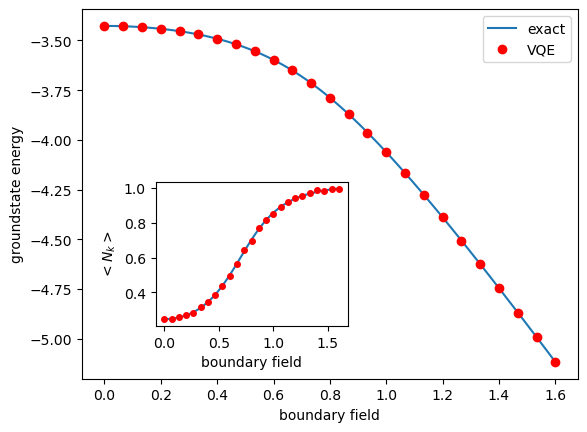

In [131]:
#Plotting
f,ax = plt.subplots()
#plt.plot(g_values,E_3,'ro')
plt.plot(exact_g_values,exact_E,label='exact')
plt.plot(g_hva,E_hva,'ro',label='VQE')
plt.xlabel('boundary field')
plt.ylabel('groundstate energy')
plt.legend()
inset_ax = f.add_axes([0.24, 0.22, 0.3, 0.3]) # [left, bottom, width, height]
plt.plot(exact_g_values,exact_kk)
plt.plot(g_hva,kk_hva,'ro',markersize=4)
inset_ax.set_xlabel('boundary field')
inset_ax.set_ylabel("$<N_k>$")
plt.show()

### Noisy simulations (HEA)

In [169]:
init_reps = 2
spsa = SPSA(maxiter=300,trust_region=True,learning_rate=0.07,perturbation=0.1)
init_spsa = SPSA(maxiter=300,trust_region=True,learning_rate=0.07,perturbation=0.1) # We consider more iterations for the first point

# To perform the whole optimization using ZNE, just set zne = True
# This step took 207 minutes to run on my machine
E_hea_noisy,angles_hea_noisy = vqe_phase_diagram(graph=graph,
                                     g_values=g_values,
                                     ansatz_str='hea',
                                     backend=backend,
                                     layers=layers_hea,
                                     optimizer=spsa,
                                     init_optimizer=init_spsa,
                                     service=service,
                                     server='noisy',
                                     device=FakeKolkata(),
                                     zne=False,
                                     shots=shots,
                                     init_reps=init_reps)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [3:27:19<00:00, 497.56s/it]  


In [176]:
# Now we run the circuits one last time with the optimal parameters
E_opt_hea_noisy,kk_opt_hea_noisy,g_hea = vqe_optimal(graph=graph,
                                 service=service,
                                 server='noisy',
                                 angles_opt=angles_hea_noisy,
                                 device=FakeKolkata(),
                                 ansatz_str='hea',
                                 layers=layers_hea,
                                 zne=False,
                                 backend=backend,
                                 shots=shots)

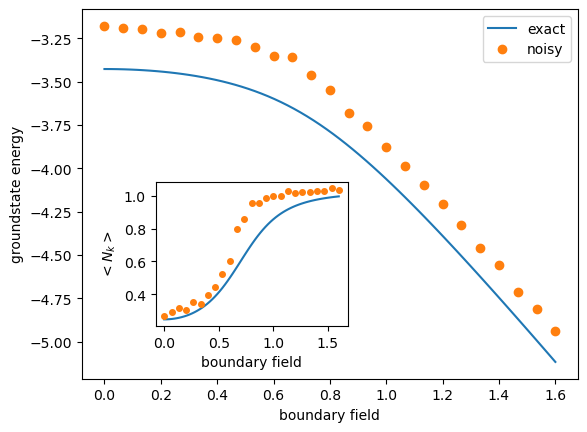

In [177]:
#Plotting
f,ax = plt.subplots()
#plt.plot(g_values,E_3,'ro')
plt.plot(exact_g_values,exact_E,label='exact')
plt.plot(g_hea,E_opt_hea_noisy,'o',label='noisy')
plt.xlabel('boundary field')
plt.ylabel('groundstate energy')
plt.legend()
inset_ax = f.add_axes([0.24, 0.22, 0.3, 0.3]) # [left, bottom, width, height]
plt.plot(exact_g_values,exact_kk)
plt.plot(g_hea,kk_opt_hea_noisy,'o',markersize=4)
inset_ax.set_xlabel('boundary field')
inset_ax.set_ylabel("$<N_k>$")
plt.show()

We now use the optimal parameters obtained with the noisy simulations to show the performance of the ZNE error mitigation protocol

In [179]:
# Now we run the circuits now using ZNE
E_opt_hea_mitigated,kk_opt_hea_mitigated,g_hea = vqe_optimal(graph=graph,
                                 service=service,
                                 server='noisy',
                                 angles_opt=angles_hea_noisy,
                                 device=FakeKolkata(),
                                 ansatz_str='hea',
                                 layers=layers_hea,
                                 zne=True,
                                 extrap='exp',
                                 backend=backend,
                                 shots=shots)

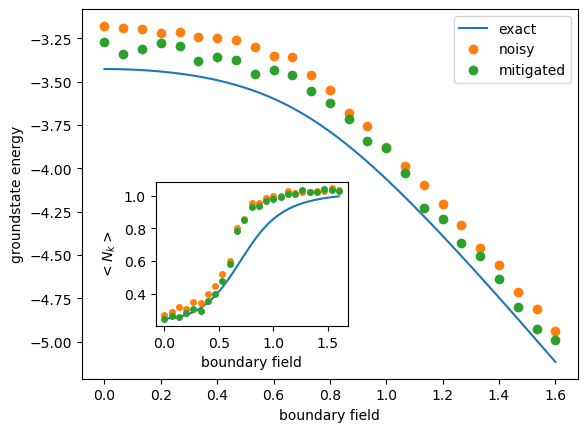

In [182]:
#Plotting
f,ax = plt.subplots()
#plt.plot(g_values,E_3,'ro')
plt.plot(exact_g_values,exact_E,label='exact')
plt.plot(g_hea,E_opt_hea_noisy,'o',label='noisy')
plt.plot(g_hea,E_opt_hea_mitigated,'o',label='mitigated')
plt.xlabel('boundary field')
plt.ylabel('groundstate energy')
plt.legend()
inset_ax = f.add_axes([0.24, 0.22, 0.3, 0.3]) # [left, bottom, width, height]
plt.plot(exact_g_values,exact_kk)
plt.plot(g_hea,kk_opt_hea_noisy,'o',markersize=4)
plt.plot(g_hea,kk_opt_hea_mitigated,'o',markersize=4)
inset_ax.set_xlabel('boundary field')
inset_ax.set_ylabel("$<N_k>$")
plt.show()

We can see that ZNE improves the fitting for both the energy and number of kinks

## Implementation of runtime

Now we use runtime with the optimal parameters obtained locally. It is not possible to perform the whole optimization on runtime because of the large extra resource overhead that runtime requires. Nevertheless, it is interesting to show the results obtained using two error mitigation protocols at once, namely, ZNE and T-REX, the latter being already implemented in qiskit. It also shows how the code presented here is easily adapted to runtime and for possible implementations on real hardware

In [186]:
# First we get the optimal parameters with statevector simulations
E_hea_noiseless,angles_hea_noiseless = vqe_phase_diagram(graph=graph,
                                     g_values=g_values,
                                     ansatz_str='hea',
                                     backend=backend,
                                     layers=layers_hea,
                                     optimizer=spsa,
                                     init_optimizer=init_spsa,
                                     service=service,
                                     server='qasm',
                                     shots=None,
                                     init_reps=init_reps)

100%|██████████| 25/25 [00:49<00:00,  1.99s/it]


In [193]:
# Setting options for runtime

# Noisy options
fake_device = FakeKolkata()
noise_model = NoiseModel.from_backend(fake_device)
options_noisy = Options()
options_noisy.execution.shots = shots
options_noisy.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_device.configuration().basis_gates,
    "coupling_map": fake_device.configuration().coupling_map,
    "seed_simulator": 42
}

options_noisy.optimization_level = 3 # no optimization
options_noisy.resilience_level = 0 # M3 for Sampler and T-REx for Estimator


# Mitigated options

options_mitigated = Options()
options_mitigated.execution.shots = shots
options_mitigated.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_device.configuration().basis_gates,
    "coupling_map": fake_device.configuration().coupling_map
}



# Set number of shots, optimization_level and resilience_level
options_mitigated.optimization_level = 3
options_mitigated.resilience_level = 1 # setting T-REX


In [194]:
# Now we run the circuits in runtime with the optimal parameters
# To run on runtime we set server = 'rtm'

# First we run the unmitigated results
E_opt_hea_noisy_rtm,kk_opt_hea_noisy_rtm,g_hea = vqe_optimal(graph=graph,
                                 service=service,
                                 server='rtm',
                                 options = options_noisy,
                                 angles_opt=angles_hea_noiseless,
                                 ansatz_str='hea',
                                 layers=layers_hea,
                                 zne=False,
                                 extrap='exp',
                                 backend=backend,
                                 shots=shots)

# Now we run using ZNE and ZNE+T-REX
# ZNE
E_opt_hea_mitigated1_rtm,kk_opt_hea_mitigated1_rtm,g_hea = vqe_optimal(graph=graph,
                                 service=service,
                                 server='rtm',
                                 options = options_noisy,
                                 angles_opt=angles_hea_noiseless,
                                 ansatz_str='hea',
                                 layers=layers_hea,
                                 zne=True,
                                 extrap='exp',
                                 backend=backend,
                                 shots=shots)

# ZNE + T-REX
E_opt_hea_mitigated2_rtm,kk_opt_hea_mitigated2_rtm,g_hea = vqe_optimal(graph=graph,
                                 service=service,
                                 server='rtm',
                                 options = options_mitigated,
                                 angles_opt=angles_hea_noiseless,
                                 ansatz_str='hea',
                                 layers=layers_hea,
                                 zne=True,
                                 extrap='exp',
                                 backend=backend,
                                 shots=shots)

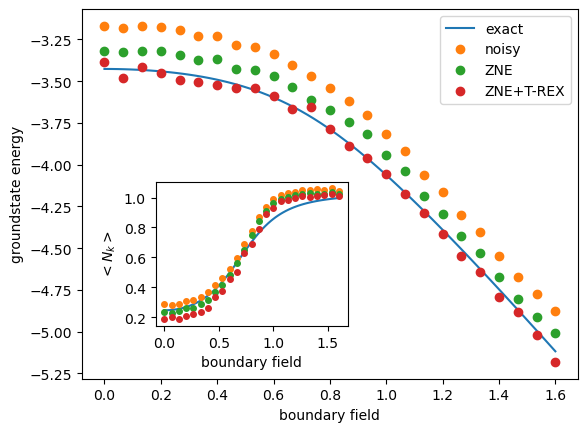

In [199]:
#Plotting
f,ax = plt.subplots()
#plt.plot(g_values,E_3,'ro')
plt.plot(exact_g_values,exact_E,label='exact')
plt.plot(g_hea,E_opt_hea_noisy_rtm,'o',label='noisy')
plt.plot(g_hea,E_opt_hea_mitigated1_rtm,'o',label='ZNE')
plt.plot(g_hea,E_opt_hea_mitigated2_rtm,'o',label='ZNE+T-REX')
plt.xlabel('boundary field')
plt.ylabel('groundstate energy')
plt.legend()
inset_ax = f.add_axes([0.24, 0.22, 0.3, 0.3]) # [left, bottom, width, height]
plt.plot(exact_g_values,exact_kk)
plt.plot(g_hea,kk_opt_hea_noisy_rtm,'o',markersize=4)
plt.plot(g_hea,kk_opt_hea_mitigated1_rtm,'o',markersize=4)
plt.plot(g_hea,kk_opt_hea_mitigated2_rtm,'o',markersize=4)
inset_ax.set_xlabel('boundary field')
inset_ax.set_ylabel("$<N_k>$")
plt.show()

We can see that the result is very near to the exact one if we consider both error mitigation methods